In [1]:
!pip install datasets

In [2]:
!pip install transformers

In [6]:
import datasets

In [7]:
#load dataset
dataset  = datasets.load_dataset('hyperpartisan_news_detection', 'bypublisher')

Reusing dataset hyperpartisan_news_detection (C:\Users\danie\.cache\huggingface\datasets\hyperpartisan_news_detection\bypublisher\1.0.0\7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)


  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
#import huggingface models
from transformers import LongformerForSequenceClassification, LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096",num_labels=2)



Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', '

In [9]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
    validation: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
})


In [10]:
train_ds = dataset["train"]
eval_ds = dataset["validation"]

In [11]:
print(type(train_ds))

<class 'datasets.arrow_dataset.Dataset'>


In [12]:
labels = map(int, train_ds['hyperpartisan'])
labels = list(labels)

labels2 = map(int, eval_ds['hyperpartisan'])
labels2 = list(labels2)



In [13]:
train_ds = train_ds.add_column("labels", labels)
eval_ds = eval_ds.add_column("labels", labels2)

In [14]:
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=2048)

In [16]:
## Take subset of data
train_size = 8000
val_size = 2000
import numpy as np

train_indices = np.random.randint(0, len(train_ds), train_size)
val_indices = np.random.randint(0, len(eval_ds), val_size)
train_ds = train_df.select(train_indices)
val_ds = eval_df.select(val_indices)

#map and store so we can run from this point later
train_dataset =  train_ds.map(tokenize, load_from_cache_file=False)
val_dataset =  val_ds.map(tokenize, load_from_cache_file=False)


0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [17]:
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

train_dataset = train_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
val_dataset = val_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
print(train_dataset)


Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 8000
})


In [18]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [19]:
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(
#     train_dataset, shuffle=True, batch_size=4, collate_fn=data_collator
# )
# eval_dataloader = DataLoader(
#     val_dataset, batch_size=4, collate_fn=data_collator
# )

In [20]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

C:\Users\danie\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
# from transformers import get_scheduler

# num_epochs = 3
# num_training_steps = num_epochs * len(train_dataloader)
# lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=num_training_steps,
# )
# print(num_training_steps)

In [22]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [24]:
from transformers import Trainer, TrainingArguments

batch_size = 2
logging_steps = len(train_dataset) // batch_size
model_name = f"longformer-finetuned"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs = 2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=False,
                                  logging_steps = logging_steps,
                                  log_level="error",
                                  fp16=True,
                                  # gradient_accumulation_steps=4,
                                  gradient_checkpointing=True,
                                  save_strategy = "epoch")

In [25]:
print(logging_steps)

4000


In [26]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [27]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.480500,0.317717,0.935000,0.934984
2,0.251500,0.276437,0.955000,0.955000


TrainOutput(global_step=8000, training_loss=0.36598949432373046, metrics={'train_runtime': 8036.4295, 'train_samples_per_second': 1.991, 'train_steps_per_second': 0.995, 'total_flos': 2.1019251572736e+16, 'train_loss': 0.36598949432373046, 'epoch': 2.0})

In [29]:
preds_output = trainer.predict(val_dataset)

In [30]:
preds_output.metrics

{'test_loss': 0.27643731236457825,
 'test_accuracy': 0.955,
 'test_f1': 0.955,
 'test_runtime': 188.7459,
 'test_samples_per_second': 10.596,
 'test_steps_per_second': 5.298}

In [31]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(val_dataset["labels"])

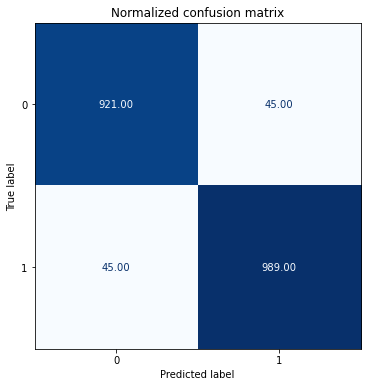

(2000,)


In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_true, labels=[0,1])
print(y_true.shape)